<div id="colab_button">
  <h1>Deploying your own BlindAI API Nitro server</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/blindbox/blob/main/docs/docs/getting-started/deploy-API-server.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>

In this guide, we'll show you how you can deploy your own instance of the BlindBox Nitro demo server featured in the Quick Tour and query the Whisper and OpenChatKit models you are serving.

## Pre-requisites
________________________

### AWS account and credits

To deploy your own BlindBox Nitro server instance, you will need an **AWS account** and **credits**.

<div class="admonition warning">
<p class="admonition-title"><b>Important</b> 💸💸 </p>
<p class="">When deploying your own Amazon EC2 R6i instance, you will be charged according to your usage as detailed by AWS. You can get a detailed pricing quote <a href="https://aws.amazon.com/ec2/pricing/" target="__blank">here</a>.<br></p>
</div>

### Dependencies

Then you'll need to install:

- [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-welcome.html), which allows us to interact with AWS cloud services via the command line.
- [Terraform](https://www.terraform.io/), which is a tool to automate a workflow where we provision the necessary Azure resources, configure our instance and deploy our enclave application.

> For alternative installation methods click [here](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html) for AWS CLI or [here](https://developer.hashicorp.com/terraform/downloads) for Terraform.

In [ ]:
# install AWS CLI
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip awscliv2.zip
!sudo ./aws/install

# check it is now installed
!aws --version

# install terraform
!wget -O- https://apt.releases.hashicorp.com/gpg | sudo gpg --dearmor -o /usr/share/keyrings/hashicorp-archive-keyring.gpg
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list
!sudo apt update && sudo apt install terraform

# check it is now installed 
!terraform --version

Next, you will need to **export your AWS credentials in the environment** you are working with.

In [ ]:
!export AWS_SECRET_ACCESS_KEY= # YOUR_AWS_SECRET_ACCESS_KEY_HERE
!export AWS_ACCESS_KEY= # YOUR_AWS_ACCESS_KEY_HERE

## Deployment
__________________________

Once everything is setup, we are ready to deploy our BlindBox server!

Before starting, we can check our AWS instance dashboard and see we have no instances currently running:

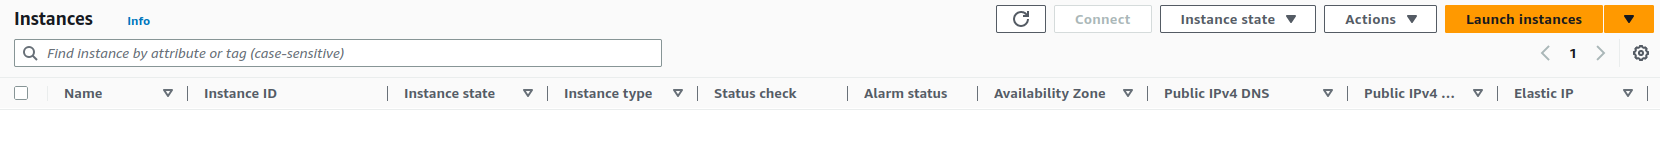

We then clone the Nitro enclave server repo and deploy the server using `terraform apply`.

In [ ]:
!git clone "https://github.com/mithril-security/whisper-fastapi"
!cd whisper-fastapi
!terraform apply

Terraform will produce some output in the terminal confirming the resources that will be allocated to us. You will notice in the details of these resources that `enclave_options`: `enabled` is set to `true`. You must select `yes` to confirm the allocation of these resources.

Terraform then runs our start script to deploy our BlindBox API application on the server instance.Now when we check out our instance dashboard on our AWS account, we can see our BlindBox Nitro server instance is now running:

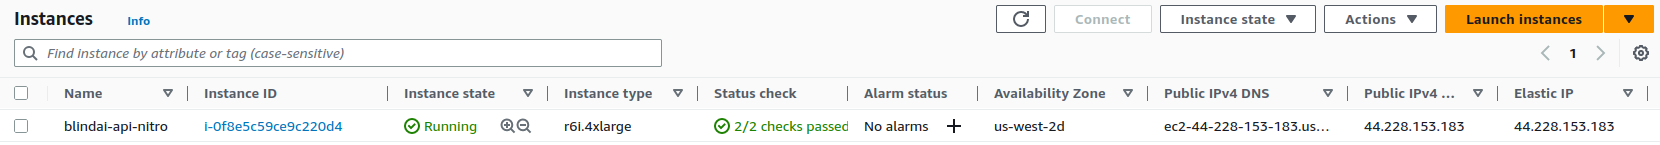

> You can now get shell access to the application's host machine on port 22. You CANNOT get shell access to the enclave for security reasons.

You can send requests directly to the enclave on port 443.

In [ ]:
!pip install requests

import requests

YOUR_INSTANCE_IP = # YOUR_INSTANCE_IP_ADDRESS_HERE
res = requests.post(
    "https://$YOUR_INSTANCE_IP/whisper/predict",
    files={
        "audio": open("test2.wav", "rb"),
    },
).text

print(res)

### Using the BlindBox API with your own server instance

You can query models on your server instance by using the `BlindBox.AI.connect()`

Let's take a look at how you can query the Whisper model with the BlindBox API using your Nitro API server.

First, you will need to install the [blindbox](https://pypi.org/project/blindbox/) **Python library** and a [test audio file](https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav), as we did in the quick tour.

> This audio file was provided by the University of Illinois at Chicago as part of their Computer Science 101 course, but you can test the API with your own audio file if you prefer!

In [ ]:
# install blindbox
!pip install blindbox

# Download our example audio file and save it as `taunt.wav`
!wget https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav -O taunt.wav

### Connection

The next step is to connect to your server instance using the `blindbox.core` connect() method and providing it with your AWS instance's IP address.

This returns to us a `BlindBoxConnection` object which we will use in the next section.

In [ ]:
#  connect to your server instance
YOUR_INSTANCE_IP = # YOUR_INSTANCE_IP_ADDRESS_HERE

client = blindbox.core.connect(
    addr=YOUR_INSTANCE_IP
)

### Transcribing the audio file

To transcribe an audio file, we call the `blindbox.ai.Audio` module's `transcribe()` method. We'll provide it with:

+ **the path to our audio file** as the `file` option. The Whisper model accepts a variety of audio file formats (m4a, mp3, mp4, mpeg, mpga, wav, webm).
+ **the enclave** as the `tee` (Trusted Execution Environment) that will be used to protect our data during computation. Our server instance uses Nitro enclaves so we need to select `nitro` here.
+ **the server instance we wish to connect to** as the `connection` option. By default, this is the Mithril-hosted Nitro server, but we will override this by providing our AWS instance IP address here.

In [ ]:
import blindbox[ai]

transcript = blindbox.ai.Audio.transcribe("taunt.wav", tee="nitro", connection=YOUR_INSTANCE_IP)

We can print out the returned `transcript` string variable to check our results are as expected.

In [ ]:
print(transcript)

Our audio file has been correctly transcribed! 

## Conclusions
_________________

In this how-to guide, we have seen:
- How to deploy your own BlindBox server instance for querying models within nitro enclaves.
- Discovered how to use the BlindBox API library with your own server instance.